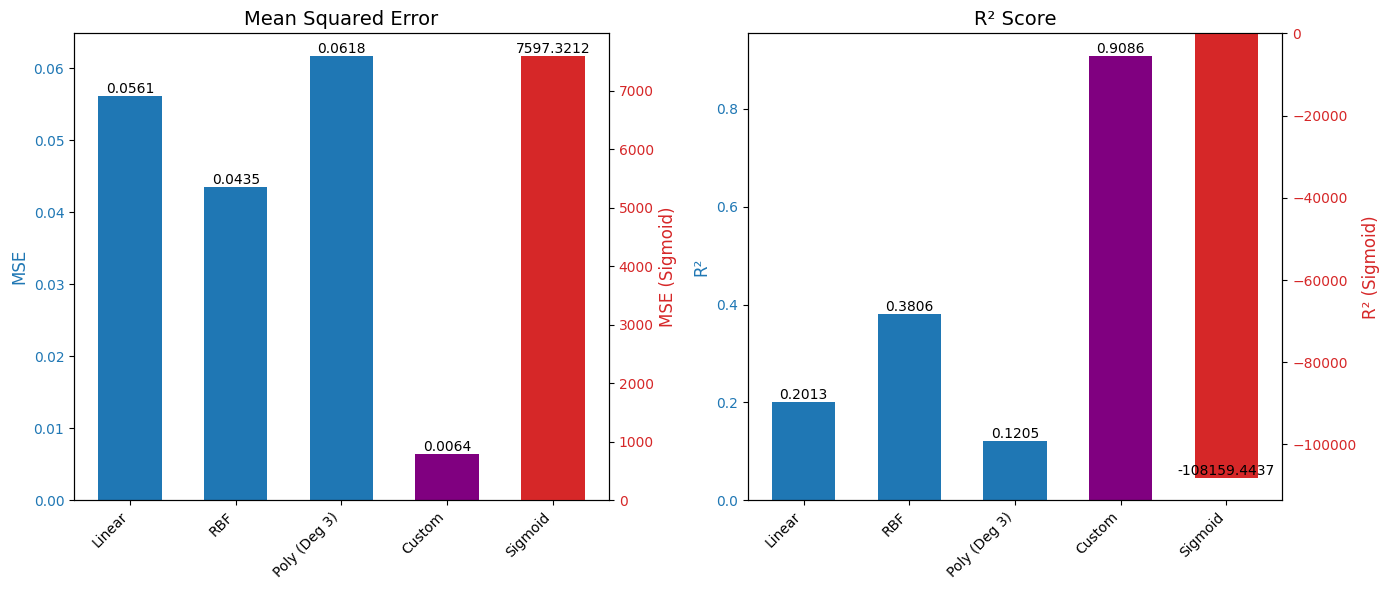

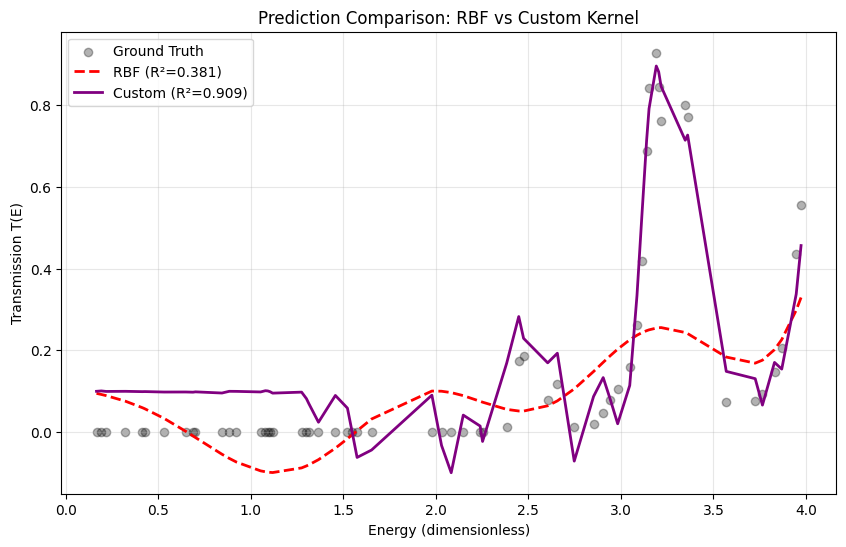

In [12]:
# -----------------------------------------------------------------------------
# Copyright (c) 2025 Renata Wong
#
# This code is supplementary material for the research paper:
# "Support Vector Machine Kernels as Quantum Propagators"
#
# Licensed under the MIT License.
# You may obtain a copy of the License at: https://opensource.org/licenses/MIT
# -----------------------------------------------------------------------------




import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# ==========================================
# 1. Physics Simulation: Fibonacci Quasicrystal
# ==========================================
def generate_fibonacci_transmission(n_samples=200, energy_range=(0, 3)):
    s0, s1 = "A", "AB"
    for _ in range(5):
        s0, s1 = s1, s1 + s0
    layers = s1
    
    energies = np.linspace(energy_range[0], energy_range[1], n_samples)
    transmission = []

    k_A = lambda E: np.sqrt(E + 0j) 
    k_B = lambda E: np.sqrt(E - 1.5 + 0j)
    
    for E in energies:
        M = np.eye(2, dtype=complex)
        for layer in layers:
            k = k_A(E) if layer == 'A' else k_B(E)
            P = np.array([[np.exp(1j * k), 0],
                          [0, np.exp(-1j * k)]])
            S = np.array([[1 - 1j/k, -1j/k],
                          [1j/k, 1 + 1j/k]]) if k != 0 else np.eye(2)
            M = np.dot(S, np.dot(P, M))
        T = 1.0 / (np.abs(M[1, 1])**2)
        transmission.append(float(T))
        
    return energies.reshape(-1, 1), np.array(transmission)

# ==========================================
# 2. Custom Kernel Implementation
# ==========================================
class JacksonChebyshevKernel:
    def __init__(self, degree=50, epsilon=0.01):
        self.degree = degree
        self.epsilon = epsilon
        self.scaler = MinMaxScaler(feature_range=(-1 + epsilon, 1 - epsilon))
        self.jackson_coeffs = self._compute_jackson_coeffs()

    def _compute_jackson_coeffs(self):
        N = self.degree
        n = np.arange(N + 1)
        term1 = (N - n + 1) * np.cos(np.pi * n / (N + 1))
        term2 = np.sin(np.pi * n / (N + 1)) / np.tan(np.pi / (N + 1))
        g_n = (term1 + term2) / (N + 1)
        return g_n

    def fit(self, X):
        self.scaler.fit(X)
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        features = []
        for i in range(X_scaled.shape[0]):
            x_val = X_scaled[i, 0]
            cheby_polys = np.cos(np.arange(self.degree + 1) * np.arccos(x_val))
            weighted_features = cheby_polys * np.sqrt(self.jackson_coeffs)
            features.append(weighted_features)
        return np.array(features)

    def compute_gram_matrix(self, X1, X2):
        Phi1 = self.transform(X1)
        Phi2 = self.transform(X2)
        return np.dot(Phi1, Phi2.T)

    def spectral_clip(self, K):
        vals, vecs = np.linalg.eigh(K)
        vals[vals < 0] = 0
        return vecs @ np.diag(vals) @ vecs.T

# ==========================================
# 3. Execution
# ==========================================
X, y = generate_fibonacci_transmission(n_samples=300, energy_range=(0.1, 4.0))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

kernels = {
    'Linear': SVR(kernel='linear', C=10),
    'RBF': SVR(kernel='rbf', C=10, gamma='scale'),
    'Poly (Deg 3)': SVR(kernel='poly', degree=3, C=10),
    'Custom': SVR(kernel='precomputed', C=10),
    'Sigmoid': SVR(kernel='sigmoid', C=10)
}

results_mse = {}
results_r2 = {}
predictions = {}  # Initialize dictionary to store prediction arrays

# --- Training Loop ---
for name, model in kernels.items():
    if name == 'Custom':
        kpm = JacksonChebyshevKernel(degree=60) 
        kpm.fit(X_train)
        K_train = kpm.compute_gram_matrix(X_train, X_train)
        K_test_local = kpm.compute_gram_matrix(X_test, X_train)
        K_train_psd = kpm.spectral_clip(K_train)
        model.fit(K_train_psd, y_train)
        y_pred = model.predict(K_test_local)
    else:
        model.fit(X_train_std, y_train)
        y_pred = model.predict(X_test_std)
    
    # Store results and PREDICTIONS (Vital for the plot)
    results_mse[name] = mean_squared_error(y_test, y_pred)
    results_r2[name] = r2_score(y_test, y_pred)
    predictions[name] = y_pred

# ==========================================
# 4. Plotting with Dual Axis (Bar Chart)
# ==========================================
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

labels = [k for k in kernels.keys() if k != 'Sigmoid']
mse_main = [results_mse[k] for k in labels]
r2_main = [results_r2[k] for k in labels]
mse_sig = results_mse['Sigmoid']
r2_sig = results_r2['Sigmoid']

# --- COLOR MODIFICATION HERE ---
# Create color list: Purple for Custom, Blue for others
colors = ['purple' if k == 'Custom' else '#1f77b4' for k in labels]

# --- Plot 1: MSE ---
x_pos = np.arange(len(labels))
width = 0.6
bars1 = ax[0].bar(x_pos, mse_main, width, label='Standard/Custom', color=colors)
ax[0].set_ylabel('MSE', color='#1f77b4', fontsize=12)
ax[0].tick_params(axis='y', labelcolor='#1f77b4')
ax[0].set_title('Mean Squared Error', fontsize=14)
ax[0].set_xticks(list(x_pos) + [len(labels)])
ax[0].set_xticklabels(labels + ['Sigmoid'], rotation=45, ha='right')

ax0_twin = ax[0].twinx()
bar2 = ax0_twin.bar(len(labels), mse_sig, width, label='Sigmoid', color='#d62728')
ax0_twin.set_ylabel('MSE (Sigmoid)', color='#d62728', fontsize=12)
ax0_twin.tick_params(axis='y', labelcolor='#d62728')

for rect in bars1:
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom')
ax0_twin.text(len(labels), mse_sig, f'{mse_sig:.4f}', ha='center', va='bottom', color='black')

# --- Plot 2: R2 ---
bars3 = ax[1].bar(x_pos, r2_main, width, label='Standard/Custom', color=colors)
ax[1].set_ylabel('R²', color='#1f77b4', fontsize=12)
ax[1].tick_params(axis='y', labelcolor='#1f77b4')
ax[1].set_title('R² Score', fontsize=14)
ax[1].set_xticks(list(x_pos) + [len(labels)])
ax[1].set_xticklabels(labels + ['Sigmoid'], rotation=45, ha='right')

ax1_twin = ax[1].twinx()
bar4 = ax1_twin.bar(len(labels), r2_sig, width, label='Sigmoid', color='#d62728')
ax1_twin.set_ylabel('R² (Sigmoid)', color='#d62728', fontsize=12)
ax1_twin.tick_params(axis='y', labelcolor='#d62728')

for rect in bars3:
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom')
ax1_twin.text(len(labels), r2_sig, f'{r2_sig:.4f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.savefig('quasicrystals_bargraph.png')
plt.show()

# ==========================================
# 5. RBF vs Custom Kernel Curve
# ==========================================
# We must sort the test data to draw a clean line, otherwise it will look like a scribble.
sort_idx = np.argsort(X_test.flatten())
X_test_sorted = X_test[sort_idx]
# Note: y_test predictions must also be reordered using the same sort_idx

plt.figure(figsize=(10, 6))

# 1. Ground Truth
plt.scatter(X_test, y_test, color='black', alpha=0.3, label='Ground Truth', zorder=1)

# 2. RBF Prediction
# We access the saved prediction array and apply the sort index
y_rbf_sorted = predictions['RBF'][sort_idx]
plt.plot(X_test_sorted, y_rbf_sorted, color='red', linestyle='--', linewidth=2, 
         label=f"RBF (R²={results_r2['RBF']:.3f})")

# 3. Custom Kernel Prediction
y_custom_sorted = predictions['Custom'][sort_idx]
plt.plot(X_test_sorted, y_custom_sorted, color='purple', linewidth=2, 
         label=f"Custom (R²={results_r2['Custom']:.3f})")

plt.title("Prediction Comparison: RBF vs Custom Kernel")
plt.xlabel("Energy (dimensionless)")
plt.ylabel("Transmission T(E)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('quasicrystals_rbf_vs_custom_curve.png')
plt.show()